# Generating Hand-written digits with Deep Convolutional GAN

In this Notebook, we show how to generate data using Deep Convolutional Neural Networks in a GAN setup.

Papers:
* [DC-GAN](https://arxiv.org/pdf/1511.06434.pdf)

In [1]:
!gpustat

phoebe  Thu May 24 11:24:45 2018
[0] GeForce GTX 1080 Ti | 68'C,  99 % |  8686 / 11172 MB | valv(7815M) s132314(861M)
[1] GeForce GTX 1080 Ti | 73'C,  73 % |  7161 / 11172 MB | valv(7151M)
[2] GeForce GTX 1080 Ti | 73'C,  59 % |  1211 / 11172 MB | valv(1201M)
[3] GeForce GTX 1080 Ti | 69'C,  67 % |  1227 / 11172 MB | valv(1217M)
[4] GeForce GTX 1080 Ti | 69'C,  48 % |  8623 / 11172 MB | valv(8613M)
[5] GeForce GTX 1080 Ti | 36'C,   1 % |     0 / 11172 MB |
[6] GeForce GTX 1080 Ti | 54'C,  11 % |   459 / 11172 MB | valv(457M)
[7] GeForce GTX 1080 Ti | 25'C,   0 % |  3898 / 11172 MB | valv(623M) valv(3265M)


In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## The Data

For this experiment, we will use the traditional MNIST dataset.

In [3]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = 'MNIST'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
L = 28

## DC-GAN 

DC-GAN is GAN with convolutional neural networks. According to the original paper, a few rules need to be respected:

* strided convolutions instead of max pooling layers
* no fully connected layers
* batch norm in $G$ and $D$
* LeayReLU for the non linearities in the discriminator

For this experiment, we keep use the Wassertein loss and the gradient penalisation from WGAN-GP, therefore **no BatchNorm** will be used for the discrimnator $D$.

### Modules

In [4]:
class Generator(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, z_size=100, out_size=1, ngf=128):
        super(Generator, self).__init__()
        self.z_size = z_size
        self.ngf = ngf
        self.out_size = out_size

        self.main = nn.Sequential(
            # input size is z_size
            nn.ConvTranspose2d(self.z_size, self.ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 3, bias=True),
            nn.Tanh()
            # state size: out_size x 64 x 64
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output

# D
class Discriminator(nn.Module):
    '''
        Discriminative Network
    '''
    def __init__(self, in_size=1, ndf=128):
        super(Discriminator, self).__init__()
        self.in_size = in_size
        self.ndf = ndf

        self.main = nn.Sequential(
            # input size is in_size x 64 x 64
            nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: ndf x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=True),
            #nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf * 2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 0, bias=True),
            #nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf * 4) x 8 x 8
            nn.Conv2d(self.ndf * 4, 1, 2, 1, 0, bias=True)
            # state size: 1 x 1 x 1
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        return self.main(input)

### Some Utilities

In [5]:
def images_to_vectors(images):
    """
    flatten batch of images
    """
    return images.view(images.size(0), L**2)

def vectors_to_images(vectors):
    """
    reconstruct batch of images from batch of flattened images
    """
    return vectors.view(vectors.size(0), 1, L, L)

def noise(size,noise_dim):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, noise_dim)
    return n.to(device)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)


def oneHot(y,data_dim):
    shp = y.size()
    y = y.view(-1,1)
    y_onehot = torch.LongTensor(y.size()[0], data_dim)
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    return y_onehot.view(*shp[:-1],data_dim).contiguous()

import torch.nn.init as init
def weights_init(m):
    if isinstance(m, nn.Conv2d): 
        if m.conv.weight is not None:
            if m.he_init:
                init.kaiming_uniform_(m.conv.weight)
            else:
                init.xavier_uniform_(m.conv.weight)
        if m.conv.bias is not None:
            init.constant_(m.conv.bias, 0.0)
    if isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

##### WGAN-GP: gradients penalty

In [23]:
LAMBDA = 10 # recommended value from the original paper

def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).requires_grad_()
    alpha = alpha[:,:,None,None]
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device) 

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)
    
    gradients = gradients[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

## Training

In [24]:
condition_dim = 10
batch_size = 128
m = int(np.sqrt(batch_size))-1
lr = 1e-3
dropout = 0.2
noise_dim = 100
num_layers = 2
n_out = L**2
clipping_value = 1e-2

num_test_samples = m**2
test_noise = noise(num_test_samples,noise_dim)[:,:,None,None]

# models
try:
    del generator
except:
    0
try:
    del discriminator
except:
    0
generator = Generator(ngf=32).to(device)
discriminator = Discriminator(ndf=32).to(device)
# otpimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)#, betas=(0,0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=lr)#, betas=(0,0.9)) #RMSprop
loss = nn.BCELoss()

# data loader
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error"])
# Total number of epochs to train
num_epochs = 200
global_step=0
epoch =0
g_error = 0

#### Training $D$

In [25]:
def train_discriminator(optimizer, real_data, real_labels, fake_data, fake_labels):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    real_input = real_data #torch.cat(real_data,real_labels],1)
    prediction_real = discriminator(real_input).squeeze()
    #loss_real = - prediction_real.mean()
    
    # 1.2 Train on Fake Data
    fake_input = fake_data #torch.cat([fake_data,fake_labels],1)
    prediction_fake = discriminator(fake_input).squeeze()
    #loss_fake = prediction_fake.mean()
    
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_input, fake_input)
    loss = prediction_fake.mean() - prediction_real.mean() + penalty
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
        
    # Return error and predictions for real and fake inputs
    return loss

#### Training $G$

In [26]:
def train_generator(optimizer, fake_data, fake_labels):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data).squeeze() #discriminator(torch.cat([fake_data,fake_labels],1))
    # Calculate error and backpropagate
    G_loss = - torch.mean(prediction)
    G_loss.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return G_loss

#### Full Training

The discrimator is trained more steps than the generator

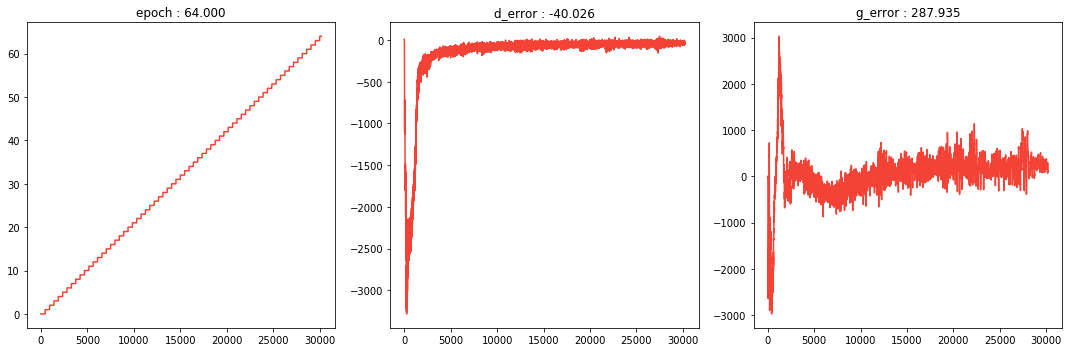

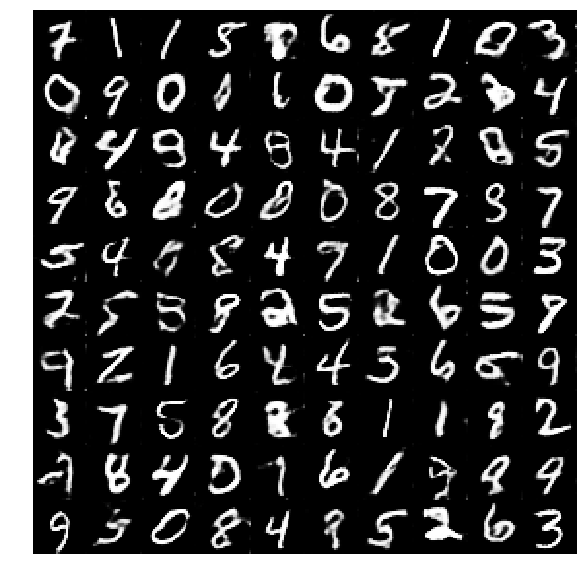

In [27]:
gen_steps = 1
gen_train_freq = 5
try:
    while True:
        for n_batch, (real_batch,label_batch) in enumerate(data_loader):
            #one hot labels
            label_batch = oneHot(label_batch[:,None],10).float().to(device)
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_data = real_batch.to(device) #images_to_vectors(real_batch).to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = noise(N,noise_dim)[:,:,None,None]
            random_labels = torch.randint(10, size=(N,1) ).long()
            random_labels = oneHot(random_labels,10).float().to(device)
            with torch.no_grad():
                fake_data = generator(noise_tensor)# torch.cat([noise_tensor,random_labels],1)).detach()
            # Train D
            d_error = train_discriminator(d_optimizer, real_data,label_batch, fake_data,random_labels)

            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # 2. Train Generator
                    # Generate fake data
                    noise_tensor = noise(N,noise_dim)[:,:,None,None]
                    random_labels = torch.randint(10, size=(N,1) ).long()
                    random_labels = oneHot(random_labels,10).float().to(device)
                    fake_data = generator(noise_tensor) #torch.cat([noise_tensor,random_labels],1))
                    # Train G
                    g_error = train_generator(g_optimizer, fake_data,random_labels)
                    g_error = g_error.item()
            # Log batch error
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error} )
            global_step+=1
            del fake_data
            del real_data
            del noise_tensor
            # Display Progress every few batches
            if global_step % 50 == 0:
                labels = torch.from_numpy(np.asarray([[k for k in range(m)] for _ in range(m)]).flatten())
                labels = oneHot(labels[:,None],10).float().to(device)
                test_images = generator(test_noise).squeeze() 
                test_images = test_images.data
                L = 28
                canvas = np.zeros((L*m,L*m))
                q = 0
                for i in range(m):
                    for j in range(m):
                        canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
                        q+=1
                dis.display(scale=False)
                plt.figure(figsize=(10,10))
                plt.imshow(canvas,cmap='gray')
                plt.axis("off")
                if False:#epoch % 50 == 0:
                    plt.savefig("DC-GAN/DC-GAN-MNIST-Epoch="+str(epoch)+".png")
                plt.show()
        epoch+=1
except:
    labels = torch.from_numpy(np.asarray([[k for k in range(m)] for _ in range(m)]).flatten())
    labels = oneHot(labels[:,None],10).float().to(device)
    test_images = generator(test_noise).squeeze() 
    test_images = test_images.data
    L = 28
    canvas = np.zeros((L*m,L*m))
    q = 0
    for i in range(m):
        for j in range(m):
            canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
            q+=1
    dis.display(scale=False)
    plt.figure(figsize=(10,10))
    plt.imshow(canvas,cmap='gray')
    plt.axis("off")
    plt.show()

## Conclusion

We have built a powerful GAN model based on convolutional neural networks. Convolutional neural networks are particularly useful in the context of image generation because they are designed to make sense of spatial features. Furthermore, the model is trained with the Wasserstein objective and gradient penalty which provides a flexible model that converges easily.